In [68]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [69]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WerPwtX7zf8rykaCv7el0AJUFTxNaUGGA2zlZ7356FDw',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'predictingtheenergyoutputofwindtu-donotdelete-pr-ydb15vhkhvxatr'
object_key = 'T1.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


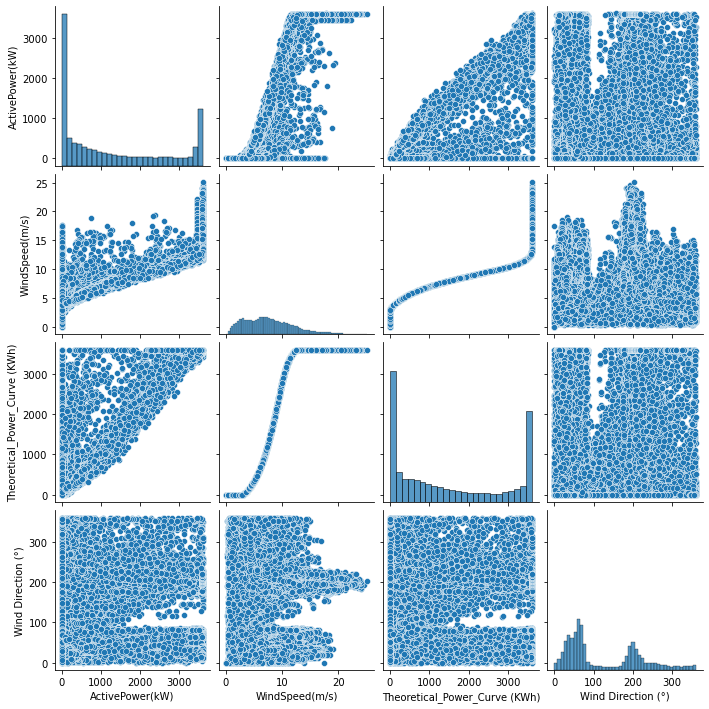

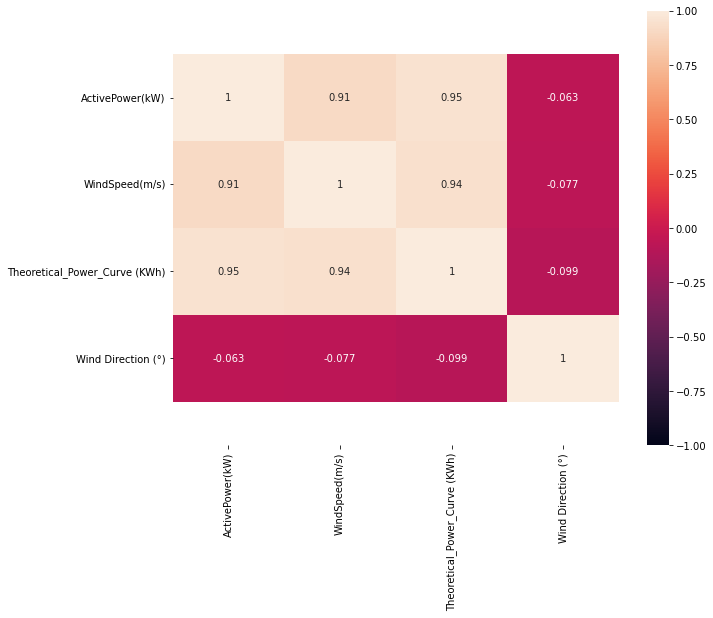

,ActivePower(kW),WindSpeed(m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
ActivePower(kW),1.000000,0.912774,0.949918,-0.062702
WindSpeed(m/s),0.912774,1.000000,0.944209,-0.077188
Theoretical_Power_Curve (KWh),0.949918,0.944209,1.000000,-0.099076
Wind Direction (°),-0.062702,-0.077188,-0.099076,1.000000


In [70]:
df.rename(columns={'Date/Time':'Time',
                   'LV ActivePower (kW)':'ActivePower(kW)',
                   "Wind Speed (m/s)":"WindSpeed(m/s)",
                   "Wind Direction (Â°)":"Wind_Direction"},
                    inplace=True)
sns.pairplot(df)
corr = df.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()
corr

In [71]:
df["Time"] = pd.to_datetime(df["Time"], format = "%d %m %Y %H:%M", errors = "coerce")
df

,Time,ActivePower(kW),WindSpeed(m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913


In [72]:
y = df['ActivePower(kW)'] #'Theoretical_Power_Curve (KWh)'
X = df[['Theoretical_Power_Curve (KWh)','WindSpeed(m/s)']]#'ActivePower(kW)'

In [73]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score

In [75]:
forest_model = RandomForestRegressor(max_leaf_nodes =500, random_state=1)
forest_model.fit(train_X, train_y)

RandomForestRegressor(max_leaf_nodes=500, random_state=1)

In [76]:
!pip install ibm_watson_machine_learning

In [77]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
                "url":"https://us-south.ml.cloud.ibm.com",
                "apikey":"3vLaYb7_R2R7GNNYiHSWjXX_iYd2gIb5jFDr-yeM1Zup"
                }
client=APIClient(wml_credentials)

In [78]:
def guid_from_space_name(client,space_name):
    space=client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [79]:
space_uid=guid_from_space_name(client,'models')
print("space UID = " + space_uid)

space UID = af1f611e-28a4-4da4-8cce-bdc546836f78


In [80]:
client.set.default_space(space_uid)

'SUCCESS'

In [81]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [82]:
model_name = "wind_mill"
deployment_name="demo_deploy"

In [83]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [84]:
model_details = client.repository.store_model(model=forest_model,meta_props={
    client.repository.ModelMetaNames.NAME:model_name,
    client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid })

In [85]:
model_id=client.repository.get_model_id(model_details)

In [86]:
model_id

'31a714e8-da95-43da-adaf-f3630556352a'

In [94]:
val_X

,Theoretical_Power_Curve (KWh),WindSpeed(m/s)
47469,609.081469,5.952496
4456,1608.179354,8.134918
49305,1650.739196,8.207115
48151,3493.172818,11.830910
33422,178.963457,4.290701
...,...,...
2269,3600.000000,13.698490
35809,0.000000,2.723258
18575,0.000000,2.186750
1194,19.326801,3.085631
